# Spark and Data Science Libraries Sample Notebook

This notebook demonstrates how to use PySpark in conjunction with pandas, numpy, scikit-learn and LightGBM for data analysis and machine learning tasks.

Created: May 7, 2025

## 1. Setting up the Spark Session

In [11]:
import os
import pyspark
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("SparkDataScienceSample") \
    .master(os.environ.get("SPARK_MASTER", "spark://spark-master:7077")) \
    .config("spark.executor.memory", "1g") \
    .getOrCreate()

print(f"Spark version: {spark.version}")
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark version: 4.0.1
Spark UI available at: http://8542eb4c79ec:4040


## 2. Creating Sample Data with PySpark

In [12]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import random

# Create a schema for our data
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("category", StringType(), False),
    StructField("value1", DoubleType(), False),
    StructField("value2", DoubleType(), False),
    StructField("target", IntegerType(), False)
])

# Generate some random data
categories = ["A", "B", "C", "D"]
data = []

for i in range(10000):
    category = random.choice(categories)
    value1 = random.uniform(0, 100)
    value2 = random.uniform(0, 100)
    # Simple rule: if value1 > 50 and category is A or B, target is 1, otherwise 0
    target = 1 if (value1 > 50 and category in ["A", "B"]) else 0
    data.append(Row(id=i, category=category, value1=value1, value2=value2, target=target))

# Create a DataFrame
df = spark.createDataFrame(data)

# Show a sample of the data
df.show(5)
print(f"Total records: {df.count()}")

# Show basic statistics
df.describe().show()

+---+--------+------------------+-----------------+------+
| id|category|            value1|           value2|target|
+---+--------+------------------+-----------------+------+
|  0|       B|  47.1158874943484|63.77743734300157|     0|
|  1|       D| 98.03319040848388|18.52974621873662|     0|
|  2|       D|  50.0114012518405|49.94608581393123|     0|
|  3|       D|21.732042340004643|66.41884190445721|     0|
|  4|       A|31.052139486880325|48.99189205558986|     0|
+---+--------+------------------+-----------------+------+
only showing top 5 rows
Total records: 10000
+-------+------------------+--------+--------------------+--------------------+-------------------+
|summary|                id|category|              value1|              value2|             target|
+-------+------------------+--------+--------------------+--------------------+-------------------+
|  count|             10000|   10000|               10000|               10000|              10000|
|   mean|            499

## 3. Converting Spark DataFrame to Pandas

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Display pandas DataFrame info
print("Pandas DataFrame Information:")
pandas_df.info()

# Basic statistics with pandas
print("\nBasic Statistics:")
print(pandas_df.describe())

# Display correlation between numeric columns
correlation = pandas_df[["value1", "value2", "target"]].corr()
print("\nCorrelation Matrix:")
print(correlation)

Pandas DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10000 non-null  int64  
 1   category  10000 non-null  object 
 2   value1    10000 non-null  float64
 3   value2    10000 non-null  float64
 4   target    10000 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 390.8+ KB

Basic Statistics:
                id        value1        value2        target
count  10000.00000  10000.000000  10000.000000  10000.000000
mean    4999.50000     50.569451     50.304253      0.252700
std     2886.89568     28.819805     28.932862      0.434582
min        0.00000      0.001729      0.001353      0.000000
25%     2499.75000     25.691145     24.828933      0.000000
50%     4999.50000     50.520882     50.895431      0.000000
75%     7499.25000     75.474822     75.208694      1.000000
max     9999.00000 

## 4. Data Visualization

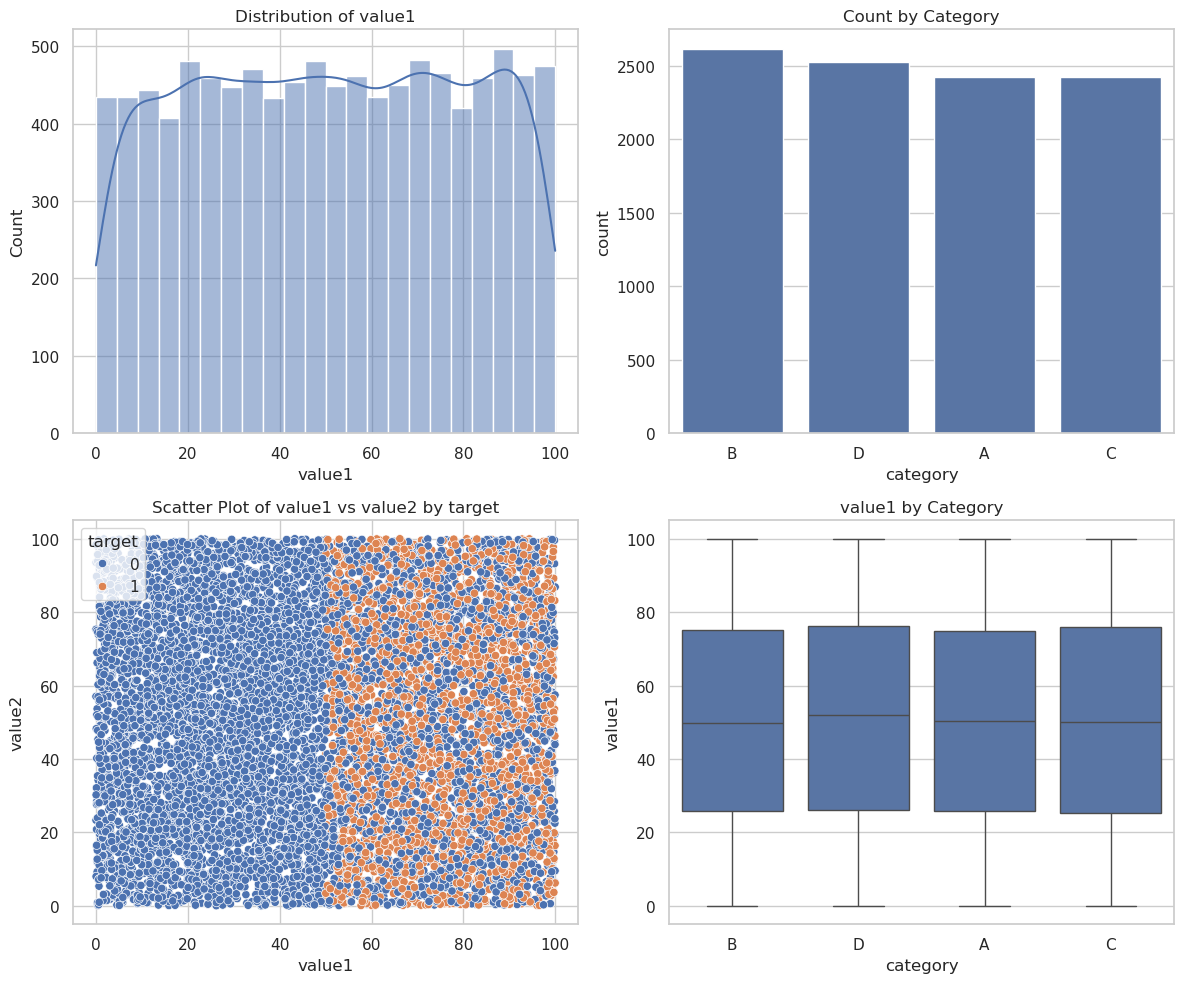

In [14]:
# Set the style for plots
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

# Create a subplot grid
plt.subplot(2, 2, 1)
sns.histplot(pandas_df["value1"], kde=True)
plt.title("Distribution of value1")

plt.subplot(2, 2, 2)
sns.countplot(x="category", data=pandas_df)
plt.title("Count by Category")

plt.subplot(2, 2, 3)
sns.scatterplot(x="value1", y="value2", hue="target", data=pandas_df)
plt.title("Scatter Plot of value1 vs value2 by target")

plt.subplot(2, 2, 4)
sns.boxplot(x="category", y="value1", data=pandas_df)
plt.title("value1 by Category")

plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [15]:
# Let's add some features using numpy and pandas
pandas_df["value_ratio"] = pandas_df["value1"] / (pandas_df["value2"] + 1)  # Adding 1 to avoid division by zero
pandas_df["value_sum"] = pandas_df["value1"] + pandas_df["value2"]
pandas_df["value_diff"] = np.abs(pandas_df["value1"] - pandas_df["value2"])
pandas_df["value1_log"] = np.log1p(pandas_df["value1"])  # log1p to avoid issues with zero

# Create dummy variables for category
category_dummies = pd.get_dummies(pandas_df["category"], prefix="category")
pandas_df = pd.concat([pandas_df, category_dummies], axis=1)

# Display the DataFrame with new features
print("DataFrame with new features:")
pandas_df.head()

DataFrame with new features:


,id,category,value1,value2,target,value_ratio,value_sum,value_diff,value1_log,category_A,category_B,category_C,category_D
0,0,B,47.115887,63.777437,0,0.727350,110.893325,16.661550,3.873612,False,True,False,False
1,1,D,98.033190,18.529746,0,5.019686,116.562937,79.503444,4.595455,False,False,False,True
2,2,D,50.011401,49.946086,0,0.981653,99.957487,0.065315,3.932049,False,False,False,True
3,3,D,21.732042,66.418842,0,0.322344,88.150884,44.686800,3.123775,False,False,False,True
4,4,A,31.052139,48.991892,0,0.621144,80.044032,17.939753,3.467364,True,False,False,False


## 6. Machine Learning with Scikit-Learn

Random Forest Performance:
Accuracy: 0.9995
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00       469

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



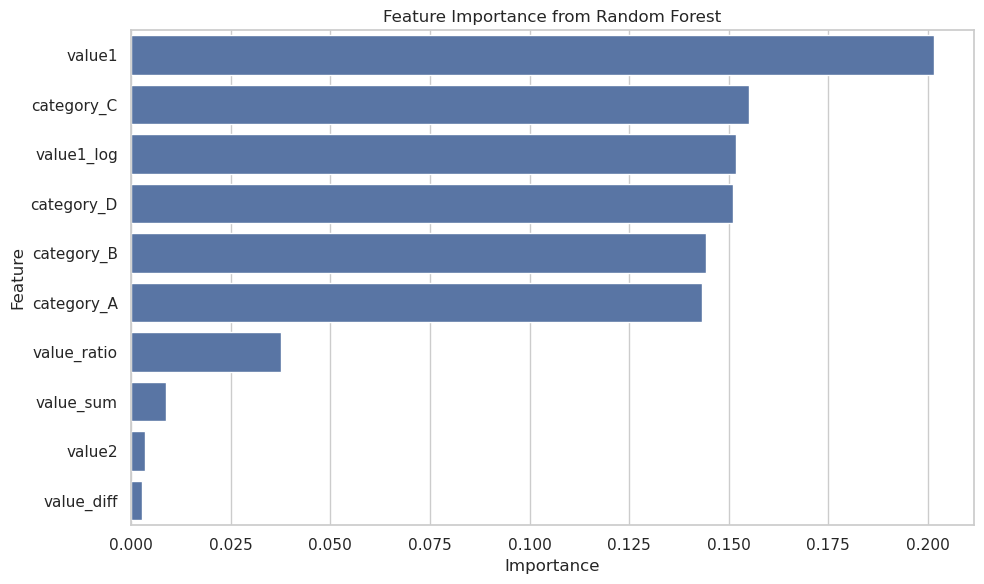

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Select features for model training
features = ["value1", "value2", "value_ratio", "value_sum", "value_diff", "value1_log", 
            "category_A", "category_B", "category_C", "category_D"]
X = pandas_df[features]
y = pandas_df["target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()

## 7. Advanced ML with LightGBM

Training LightGBM model...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

<Figure size 1000x600 with 0 Axes>

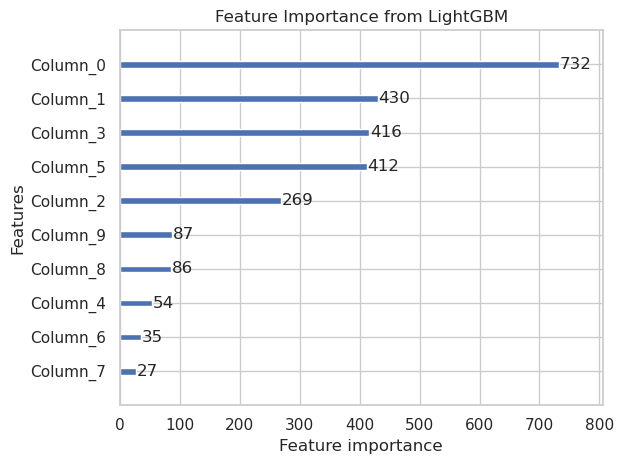

In [17]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_test = lgb.Dataset(X_test_scaled, y_test, reference=lgb_train)

# Set parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
print("Training LightGBM model...")
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=100,
                      valid_sets=[lgb_train, lgb_test],
                      # early_stopping_rounds=10
                     )

# Make predictions
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_binary_pred = [1 if pred > 0.5 else 0 for pred in lgb_pred]

# Evaluate the model
print("\nLightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, lgb_binary_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, lgb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lgb_binary_pred))

# Plot feature importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("Feature Importance from LightGBM")
plt.tight_layout()
plt.show()

## 8. Going Back to Spark - Saving Results to Spark DataFrame

In [18]:
# Add predictions to our pandas DataFrame
test_indices = pandas_df.iloc[y_test.index].index
pandas_df.loc[test_indices, "rf_prediction"] = y_pred
pandas_df.loc[test_indices, "rf_probability"] = y_prob
pandas_df.loc[test_indices, "lgb_prediction"] = lgb_binary_pred
pandas_df.loc[test_indices, "lgb_probability"] = lgb_pred

# Convert back to a Spark DataFrame
result_spark_df = spark.createDataFrame(pandas_df)
result_spark_df.show(5)

# Register as a temporary view for SQL queries
result_spark_df.createOrReplaceTempView("model_results")

# Example: Run a Spark SQL query
print("\nAnalyzing model results using Spark SQL:")
spark.sql("""
SELECT 
    category,
    COUNT(*) as total_count,
    SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) as actual_positive,
    SUM(CASE WHEN rf_prediction = 1 THEN 1 ELSE 0 END) as rf_predicted_positive,
    SUM(CASE WHEN lgb_prediction = 1 THEN 1 ELSE 0 END) as lgb_predicted_positive
FROM model_results
GROUP BY category
ORDER BY category
""").show()

+---+--------+------------------+-----------------+------+-------------------+------------------+-------------------+------------------+----------+----------+----------+----------+-------------+--------------+--------------+--------------------+
| id|category|            value1|           value2|target|        value_ratio|         value_sum|         value_diff|        value1_log|category_A|category_B|category_C|category_D|rf_prediction|rf_probability|lgb_prediction|     lgb_probability|
+---+--------+------------------+-----------------+------+-------------------+------------------+-------------------+------------------+----------+----------+----------+----------+-------------+--------------+--------------+--------------------+
|  0|       B|  47.1158874943484|63.77743734300157|     0| 0.7273502847120381|110.89332483734998| 16.661549848653173| 3.873612423912042|     false|      true|     false|     false|          0.0|           0.0|           0.0|0.001720429291109...|
|  1|       D| 9

## 9. Close Spark Session when Done

In [19]:
# Stop the Spark session
# Uncomment this when you want to close the Spark session
spark.stop()

print("Notebook completed successfully!")

Notebook completed successfully!
